In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi


Sat Jan  4 10:00:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0              31W /  70W |    149MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Check if the drive is properly mounted
import os
print("Is Google Drive mounted?", os.path.exists('/content/drive'))

Is Google Drive mounted? True


In [ ]:
parent_folder = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
if os.path.isdir(parent_folder):
    print("Parent folder contents:", os.listdir(parent_folder))
else:
    print("Parent folder does not exist.")

Parent folder contents: ['Normal-10164.png', 'Normal-1015.png', 'Normal-102.png', 'Normal-1034.png', 'Normal-10188.png', 'Normal-1023.png', 'Normal-1024.png', 'Normal-10189.png', 'Normal-1063.png', 'Normal-1058.png', 'Normal-1048.png', 'Normal-1051.png', 'Normal-1050.png', 'Normal-1061.png', 'Normal-1089.png', 'Normal-1099.png', 'Normal-1087.png', 'Normal-1104.png', 'Normal-1125.png', 'Normal-1115.png', 'Normal-1124.png', 'Normal-1126.png', 'Normal-1113.png', 'Normal-1137.png', 'Normal-1160.png', 'Normal-1166.png', 'Normal-1168.png', 'Normal-1174.png', 'Normal-12.png', 'Normal-1243.png', 'Normal-1227.png', 'Normal-124.png', 'Normal-1251.png', 'Normal-1235.png', 'Normal-1257.png', 'Normal-1284.png', 'Normal-1291.png', 'Normal-1275.png', 'Normal-126.png', 'Normal-1285.png', 'Normal-132.png', 'Normal-1309.png', 'Normal-1335.png', 'Normal-1331.png', 'Normal-1358.png', 'Normal-1356.png', 'Normal-136.png', 'Normal-1352.png', 'Normal-137.png', 'Normal-1407.png', 'Normal-1408.png', 'Normal-141

In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision import datasets
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.RandomHorizontalFlip(),         # Randomly flip images
    transforms.ToTensor(),                     # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize images to 224x224
    transforms.ToTensor(),                     # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])


In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

# Define a custom dataset class
class CustomCovidNormalDataset(Dataset):
    def __init__(self, normal_dir, covid_dir, transform=None):
        self.normal_images = [(os.path.join(normal_dir, f), 0) for f in os.listdir(normal_dir)]  # Label 0 for Normal
        self.covid_images = [(os.path.join(covid_dir, f), 1) for f in os.listdir(covid_dir)]  # Label 1 for Covid
        self.images = self.normal_images + self.covid_images  # Combine both
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Define directories
normal_train_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal train/'
covid_train_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid train/'

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (for DenseNet)
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standardize based on ImageNet stats
])

# Load the custom dataset
train_dataset = CustomCovidNormalDataset(normal_train_dir, covid_train_dir, transform=transform)

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Verify data loading
print(f'Training Data: {len(train_loader.dataset)} images')


Training Data: 11065 images


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)

# Modify the final layer to output 2 classes (Covid, Normal)
model.classifier = nn.Linear(model.classifier.in_features, 2)

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the model summary (optional)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
# Define loss function (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Epoch 1/10: 100%|██████████| 173/173 [1:04:06<00:00, 22.24s/batch]


Epoch [1/10], Loss: 0.0758, Accuracy: 97.50%


Epoch 2/10: 100%|██████████| 173/173 [03:17<00:00,  1.14s/batch]


Epoch [2/10], Loss: 0.0129, Accuracy: 99.61%


Epoch 3/10: 100%|██████████| 173/173 [03:17<00:00,  1.14s/batch]


Epoch [3/10], Loss: 0.0086, Accuracy: 99.74%


Epoch 4/10: 100%|██████████| 173/173 [03:14<00:00,  1.12s/batch]


Epoch [4/10], Loss: 0.0038, Accuracy: 99.90%


Epoch 5/10: 100%|██████████| 173/173 [03:15<00:00,  1.13s/batch]


Epoch [5/10], Loss: 0.0049, Accuracy: 99.87%


Epoch 6/10: 100%|██████████| 173/173 [03:14<00:00,  1.12s/batch]


Epoch [6/10], Loss: 0.0065, Accuracy: 99.81%


Epoch 7/10: 100%|██████████| 173/173 [03:15<00:00,  1.13s/batch]


Epoch [7/10], Loss: 0.0033, Accuracy: 99.88%


Epoch 8/10: 100%|██████████| 173/173 [03:15<00:00,  1.13s/batch]


Epoch [8/10], Loss: 0.0006, Accuracy: 99.99%


Epoch 9/10: 100%|██████████| 173/173 [03:14<00:00,  1.13s/batch]


Epoch [9/10], Loss: 0.0002, Accuracy: 100.00%


Epoch 10/10: 100%|██████████| 173/173 [03:14<00:00,  1.13s/batch]


Epoch [10/10], Loss: 0.0024, Accuracy: 99.92%


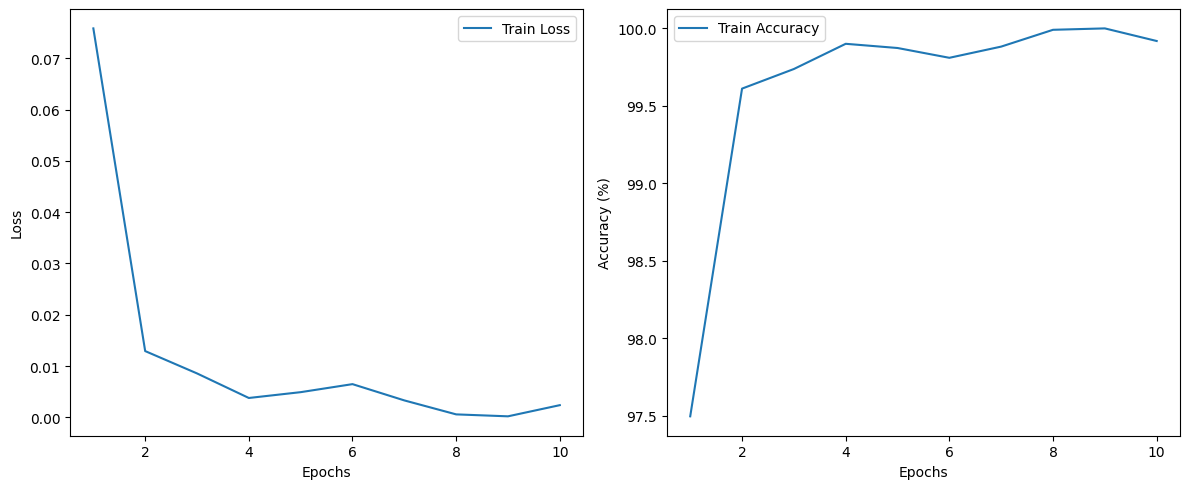

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)

# Define lists to track loss and accuracy
train_loss = []
train_acc = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Using tqdm for progress bar during training
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        # Move data to the same device as model
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Track loss
        running_loss += loss.item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples * 100

    # Store the loss and accuracy for plotting
    train_loss.append(epoch_loss)
    train_acc.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# After training, plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plotting the loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Save the model's state_dict (weights)
# Uncomment the bellow line if you want to save your newly traned model #
#!!torch.save(model.state_dict(), '/content/drive/MyDrive/Covid_xrays_classifier/model.pth')
#print("Model saved successfully!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-18-6617d090ea62>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more

Test Accuracy: 97.68%


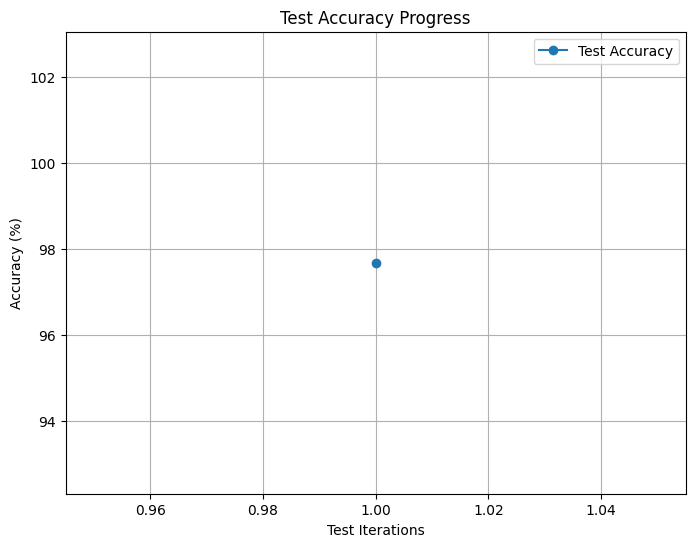

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import models

# Directories for test dataset
normal_test_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
covid_test_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid test'

# Define the transformations (ensure it's the same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensuring the input size is consistent
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create DataLoader for the test dataset
test_dataset = CustomCovidNormalDataset(normal_test_dir, covid_test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the pre-trained model
model = models.densenet121(pretrained=True)  # Using pretrained=True to start with a model with weights
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)  # Modify the final layer to match your task

# Load the saved weights from the trained model
model.load_state_dict(torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', map_location=torch.device('cpu')))

# Set model to evaluation mode (important for inference)
model.eval()

# Move the model to the CPU (ensure the model is on the correct device)
model.to(torch.device('cpu'))

# List to track the accuracy over multiple tests (if you plan on testing multiple times)
test_accuracies = []

# Variables to track correct predictions and total samples
correct_predictions = 0
total_samples = 0

# tqdm for the progress bar in test loop
with torch.no_grad():  # No need to compute gradients for testing
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        # Ensure both inputs and labels are on the correct device (CPU)
        inputs, labels = inputs.to(torch.device('cpu')), labels.to(torch.device('cpu'))

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Update the count of correct predictions and total samples
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate and print test accuracy
test_accuracy = (correct_predictions / total_samples) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Append the test accuracy to the list for potential future plotting
test_accuracies.append(test_accuracy)

# Plotting the accuracy over test iterations (if running multiple tests)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Test Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Progress')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
##################################   SECOND IMPLEMENTATION of class/on report #########################


import torch
from sklearn.metrics import classification_report
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you have the paths to your validation dataset directories
normal_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
covid_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid test'

# Define the transformations (you can modify this as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the validation dataset (you'll need to define CustomCovidNormalDataset elsewhere in your code)
val_dataset = CustomCovidNormalDataset(normal_val_dir, covid_val_dir, transform=transform)

# Create the validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Now, val_loader is ready to be used in the prediction and evaluation code

# Load the model (it was saved in model.pth)
model = models.densenet121(pretrained=True)

# Modify the classifier to output 2 classes (Covid, Normal)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)

# Load the saved weights for all layers
model.load_state_dict(torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', map_location=torch.device('cpu')))

# Move the model to CPU (in case it was previously using GPU)
device = torch.device("cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Store the true labels and predictions
true_labels = []
predictions = []

# Assuming you have the val_loader already defined
with torch.no_grad():  # No need to compute gradients for validation
    # Use tqdm for a progress bar during validation
    for inputs, labels in tqdm(val_loader, desc="Evaluating", leave=True):  # Wrap the loop with tqdm
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure both are on CPU
        outputs = model(inputs)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        # Store the true labels and predictions
        true_labels.extend(labels.numpy())  # Move to CPU before appending
        predictions.extend(predicted.numpy())

# Print the classification report (Precision, Recall, F1-score)
report = classification_report(true_labels, predictions, target_names=['Normal', 'Covid'])
print(report)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=De

              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98      1020
       Covid       1.00      0.91      0.95       362

    accuracy                           0.98      1382
   macro avg       0.98      0.96      0.97      1382
weighted avg       0.98      0.98      0.98      1382



In [ ]:
# Create DataLoader for validation or test
val_dataset = CustomCovidNormalDataset(normal_val_dir, covid_val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluation loop
model.eval()  # Set model to evaluation mode
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate validation accuracy
val_accuracy = correct_predictions / total_samples * 100
print(f'Validation Accuracy: {val_accuracy:.2f}%')


In [ ]:
# Load the saved weights with map_location='cpu' to ensure it's loaded on CPU
model.load_state_dict(torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', map_location=torch.device('cpu')))

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-47-34e2ed67bbc4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', 

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Directories for test dataset
normal_test_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
covid_test_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid test'

# Create DataLoader for test dataset
test_dataset = CustomCovidNormalDataset(normal_test_dir, covid_test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model evaluation
model.eval()  # Set model to evaluation mode
correct_predictions = 0
total_samples = 0

# Test loop with tqdm progress bar
with torch.no_grad():
    # Adding tqdm to show a progress bar
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate test accuracy
test_accuracy = correct_predictions / total_samples * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')



Testing: 100%|██████████| 44/44 [05:19<00:00,  7.26s/batch]

Test Accuracy: 97.68%


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar

# Assuming you have the paths to your validation dataset directories
normal_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
covid_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid test'

# Define the transformations (you can modify this as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the validation dataset (you'll need to define CustomCovidNormalDataset elsewhere in your code)
val_dataset = CustomCovidNormalDataset(normal_val_dir, covid_val_dir, transform=transform)

# Create the validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load the model (it was saved in model.pth)
model = models.densenet121(pretrained=True)  # Set pretrained=True as you did during initial setup

# Modify the classifier to output 2 classes (Covid, Normal)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)

# Load the saved weights for all layers except the classifier (this is necessary since the classifier has 2 outputs)
checkpoint = torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', map_location=torch.device('cpu'))

# Filter out the classifier weights and load the rest of the model weights
checkpoint = {k: v for k, v in checkpoint.items() if 'classifier' not in k}
model.load_state_dict(checkpoint, strict=False)

# Move the model to CPU (in case it was previously using GPU)
model.to(torch.device('cpu'))

# Set the model to evaluation mode
model.eval()

# Store the true labels, predictions, and probabilities
true_labels = []
predictions = []
probs = []  # To store the class probabilities

# Assuming you have the val_loader already defined
with torch.no_grad():  # No need to compute gradients for validation
    # Use tqdm for a progress bar during validation
    for inputs, labels in tqdm(val_loader, desc="Evaluating", leave=True, unit="batch"):  # Wrap the loop with tqdm
        inputs, labels = inputs.to(torch.device('cpu')), labels.to(torch.device('cpu'))  # Ensure both are on CPU
        outputs = model(inputs)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        # Store the true labels and predictions
        true_labels.extend(labels.numpy())  # Move to CPU before appending
        predictions.extend(predicted.numpy())

        # Get the probabilities for each class (using softmax)
        prob = torch.nn.functional.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        probs.extend(prob.numpy())  # Store probabilities

# Print the classification report (Precision, Recall, F1-score)
report = classification_report(true_labels, predictions, target_names=['Normal', 'Covid'])
print(report)

# Calculate AUC (Area Under the Curve)
# We need the probabilities for the positive class (Covid = 1)
# Convert the probabilities to numpy arrays and calculate AUC for the positive class
probs = np.array(probs)  # Convert to numpy array
auc = roc_auc_score(true_labels, probs[:, 1])  # Use the probability of the positive class (Covid)
print(f"AUC: {auc:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-49-58e30524cdc1>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

              precision    recall  f1-score   support

      Normal       0.74      1.00      0.85      1020
       Covid       0.00      0.00      0.00       362

    accuracy                           0.74      1382
   macro avg       0.37      0.50      0.42      1382
weighted avg       0.54      0.74      0.63      1382

AUC: 0.2390



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
######################## Performance analysis using precision, recal, f1 #################################
######################## Skicit learn - Classification report            #################################
######################## Running on CPU                                  #################################
import torch
from sklearn.metrics import classification_report
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  #tqdm for progress bar

# Assuming you have the paths to your validation dataset directories
normal_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/normal_dataset/normal test'
covid_val_dir = '/content/drive/MyDrive/Covid_xrays_classifier/xray_covid19_dataset/Covid_dataset/Covid test'

# Define the transformations (you can modify this as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the validation dataset (you'll need to define CustomCovidNormalDataset elsewhere in your code)
val_dataset = CustomCovidNormalDataset(normal_val_dir, covid_val_dir, transform=transform)

# Create the validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Now, val_loader is ready to be used in the prediction and evaluation code

# Load the model (it was saved in model.pth)
model = models.densenet121(pretrained=True)  # Set pretrained=True as you did during initial setup

# Modify the classifier to output 2 classes (Covid, Normal)
model.classifier = torch.nn.Linear(model.classifier.in_features, 2)

# Load the saved weights for all layers except the classifier (this is necessary since the classifier has 2 outputs)
checkpoint = torch.load('/content/drive/MyDrive/Covid_xrays_classifier/model.pth', map_location=torch.device('cpu'))

# Filter out the classifier weights and load the rest of the model weights
checkpoint = {k: v for k, v in checkpoint.items() if 'classifier' not in k}
model.load_state_dict(checkpoint, strict=False)

# Move the model to CPU (in case it was previously using GPU)
model.to(torch.device('cpu'))

# Set the model to evaluation mode
model.eval()

# Store the true labels and predictions
true_labels = []
predictions = []

# Assuming you have the val_loader already defined
with torch.no_grad():  # No need to compute gradients for validation
    # Use tqdm for a progress bar during validation
    for inputs, labels in tqdm(val_loader, desc="Evaluating", leave=False):  # Wrap the loop with tqdm
        inputs, labels = inputs.to(torch.device('cpu')), labels.to(torch.device('cpu'))  # Ensure both are on CPU
        outputs = model(inputs)

        # Get predicted class
        _, predicted = torch.max(outputs, 1)

        # Store the true labels and predictions
        true_labels.extend(labels.numpy())  # Move to CPU before appending
        predictions.extend(predicted.numpy())

# Print the classification report (Precision, Recall, F1-score)
report = classification_report(true_labels, predictions, target_names=['Normal', 'Covid'])
print(report)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=De

              precision    recall  f1-score   support

      Normal       0.94      1.00      0.96      1020
       Covid       0.99      0.81      0.89       362

    accuracy                           0.95      1382
   macro avg       0.96      0.90      0.93      1382
weighted avg       0.95      0.95      0.94      1382

